In [1]:
# ignore warnings 
import warnings
warnings.filterwarnings('ignore')
import os
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import ast
from bisect import bisect_left
# import Counter
from collections import Counter

from scipy.signal import find_peaks
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
load_dotenv()
base_dir = os.getenv("SCRATCH_DIR")
# base_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(base_dir, "data")
behav_dir = os.path.join(data_dir, "behav")
stimuli_dir = os.path.join(data_dir, "stimuli")

In [10]:
pavlovia_df = pd.read_excel(os.path.join(behav_data_dir, "pavlovia.xlsx"))
postsurvey_df = pd.read_csv(os.path.join(behav_data_dir, "postsurvey.csv"))
prolific_df = pd.read_csv(os.path.join(behav_data_dir, "prolific_ids.csv"))
print(pavlovia_df.shape, postsurvey_df.shape, prolific_df.shape)

(139, 3) (149, 29) (120, 19)


In [11]:
pp_ids = prolific_df["Participant id"].values
# select rows in pavlovia_df that have pp_ids in prolific_df
pavlovia_df2 = pavlovia_df[pavlovia_df["participant"].isin(pp_ids)]
# do the same for postsurvey_df
postsurvey_df2 = postsurvey_df[postsurvey_df["participant"].isin(pp_ids)]
postsurvey_df3 = postsurvey_df2[['ch1', 'ch2', 'ch3', 'recall', 'engagement', 'clarity', 'age', 'gender', 'participant']]
print(pavlovia_df2.shape, postsurvey_df3.shape)

(118, 3) (118, 9)


In [12]:
# merge the two dataframes based on the participant column
merged_df = pd.merge(pavlovia_df2, postsurvey_df3, on="participant")
print(merged_df.shape)

(118, 11)


In [13]:
# Remove BOM
merged_df['key_resp_2.rt'] = merged_df['key_resp_2.rt'].str.replace('\ufeff', '', regex=False)
# Convert string representation of lists to actual lists
merged_df['event_seg'] = merged_df['key_resp_2.rt'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)
# Filter elements with exactly 3 digits after the decimal point using NumPy
merged_df['event_seg'] = merged_df['event_seg'].apply(
    lambda x: np.around(x, decimals=3)
)

## Resample seconds to TRs (Bin methods)

In our pavlovia experiment, the stimulus was presented in the same way as it was in the fmri scanner—began with 18 seconds of neutral introductory music followed by 3 seconds of silence, such that the story started at 0:21 (after 14 TRs) and ended at 11:37, for a duration of 676 seconds (~451 TRs)—except that we only added 5 seconds (~3 TRs) instead of 15 seconds (10 TRs) of silence at the end of the story.

So our pavlovia stimulus is 21+676+5 = 702 seconds long, which is 468  TRs.

The bin method is that we want to convert anything between 0 and 1.5 to 1, anything between 1.5 and 3 to 2, and anything between 3 and 5 to 3, etc.

Mathematically speaking, we want to round up to the ceiling of the number divided by 1.5, and if someone pressed the space bar twice within a TR, we only count it once.

In [14]:
def seconds2TRs(resp_seconds):
    resp_seconds = np.array(resp_seconds)
    resp_TRs = np.ceil(resp_seconds / 1.5)
    resp_TRs = np.unique(resp_TRs)
    return resp_TRs

In [15]:
merged_df['event_seg_TRs'] = merged_df['event_seg'].apply(seconds2TRs)
merged_df.head()

,participant,key_resp_1.rt,key_resp_2.rt,ch1,ch2,ch3,recall,engagement,clarity,age,gender,event_seg,event_seg_TRs
0,6070b8550e199cd6db5e4a79,28.7922,"[51.927900000035756,94.9035,178.6211,202.9921,...",Lee,Arthur,Mary,"Lee and Mary were sitting close together, appa...",7,9,25-34 years old,Female,"[51.928, 94.904, 178.621, 202.992, 241.176, 28...","[35.0, 64.0, 120.0, 136.0, 161.0, 190.0, 204.0..."
1,60baaa995c09d3162511871d,64.8632,"[83.0235999994278,119.187,132.3696,189.632,242...",Don't know,Arthur,Don't know,This story was incredibly hard for me to follo...,4,7,35-44 years old,Male,"[83.024, 119.187, 132.37, 189.632, 242.675, 25...","[56.0, 80.0, 89.0, 127.0, 162.0, 169.0, 184.0,..."
2,6100943a3afefd2133a6f0f7,32.3460,"[28.583,32.491,35.375,41.56,50.441,59.726,66.1...",Lee,Arthur,Don't know,The story takes place in New York City. An old...,7,6,18-24 years old,Female,"[28.583, 32.491, 35.375, 41.56, 50.441, 59.726...","[20.0, 22.0, 24.0, 28.0, 34.0, 40.0, 45.0, 47...."
3,5cead89f7832f40018ca2245,48.7388,"[52.22260000038148,81.6475,98.1323,222.1914,23...",Don't know,Don't know,Don't know,I remember that there's a grey haired man and ...,7,4,25-34 years old,Female,"[52.223, 81.648, 98.132, 222.191, 232.965, 299...","[35.0, 55.0, 66.0, 149.0, 156.0, 200.0, 251.0,..."
4,6462aa815636e19bb0eefbd3,21.3484,"[42.076600000023845,51.4786,76.2976,87.1831,10...",Lee,Arthur,Joanie,Lee was at home with the young girl. I don't k...,7,7,45-54 years old,Female,"[42.077, 51.479, 76.298, 87.183, 108.468, 123....","[29.0, 35.0, 51.0, 59.0, 73.0, 83.0, 99.0, 108..."


## Get the aggreement on those key presses

In [16]:
def get_agreement(response_col, unit, df):
    all_responses = []
    for i, row in enumerate(df[response_col]):
        # Skip over None or NaN values
        if row is None or (isinstance(row, float) and np.isnan(row)):
            continue
        all_responses.extend(row)
    # Count the occurrences of each unique element
    response_counts = Counter(all_responses)
    # Create a new DataFrame
    agreement_df = pd.DataFrame(list(response_counts.items()), columns=[unit, 'count'])
    # drop nan based on TR
    agreement_df = agreement_df.dropna(subset=[unit])
    # Sort by TR for better readability
    agreement_df = agreement_df.sort_values(by=unit).reset_index(drop=True)
    agreement_df['agreement'] = agreement_df['count'] / df.shape[0]
    # remove the first 14 TRs/21s and the last 3 TRs
    if unit == 'TR':
        agreement_df = agreement_df[(agreement_df[unit] > 14)&(agreement_df[unit] < 467)]
    elif unit == 'second':
        agreement_df = agreement_df[(agreement_df[unit] > 21)&(agreement_df[unit] < 699)]
    else:
        print("Please enter a valid unit: TR or second")
    # reset index
    agreement_df = agreement_df.reset_index(drop=True)
    return agreement_df

In [17]:
agree_TR_df = get_agreement('event_seg_TRs', 'TR', merged_df)
agree_TR_df.describe()

,TR,count,agreement
count,409.000000,409.000000,409.000000
mean,243.051345,5.161369,0.043740
std,128.380332,4.488370,0.038037
min,15.000000,1.000000,0.008475
25%,133.000000,2.000000,0.016949
50%,245.000000,4.000000,0.033898
75%,352.000000,7.000000,0.059322
max,466.000000,27.000000,0.228814


In [18]:
agree_TR_df

,TR,count,agreement
0,15.0,2,0.016949
1,16.0,1,0.008475
2,19.0,1,0.008475
3,20.0,7,0.059322
4,21.0,2,0.016949
...,...,...,...
404,462.0,2,0.016949
405,463.0,3,0.025424
406,464.0,15,0.127119
407,465.0,11,0.093220


## Find peaks

### Get continuous time series

In [28]:
# we need to convert countered responses to a time series dataframe
def get_tsdf(df, unit):
    df2 = pd.DataFrame(columns=[unit, "agreement"])
    min_val = 0
    max_val = df[unit].max()+1
    df2[unit] = np.arange(min_val, max_val, 1)
    for i, row in enumerate(df2[unit]):
        if row in df[unit].values:
            df2.at[i, "agreement"] = df[df[unit] == row]["agreement"].values[0]
        else:
            df2.at[i, "agreement"] = 0
    # convert to float
    df2["agreement"] = df2["agreement"].astype(float)
    # df2[unit] = df2[unit]-min_val
    return df2

In [23]:
def plot_peaks(df, unit, all_peaks, prominent_peaks, prominence):
    # check if unit is TR or second if not return error
    if unit != "TR" and unit != "second":
        print("Please enter a valid unit: TR or second")
        return
    plt.figure(figsize=(15, 6))
    plt.plot(df[unit], df['agreement'], label="Agreement")
    plt.plot(df[unit].iloc[all_peaks], df['agreement'].iloc[all_peaks], "x", label="All Peaks")
    plt.plot(df[unit].iloc[prominent_peaks], df['agreement'].iloc[prominent_peaks], "o", label=f"Prominent Peaks ({prominence})")
    plt.legend()
    plt.title("Peaks in Agreement")
    plt.xlabel(f"Time ({unit})")
    plt.ylabel("Agreement")
    plt.show()

In [29]:
agree_TR_df2 = get_tsdf(agree_TR_df, "TR")
agree_TR_df2.describe()

,TR,agreement
count,467.000000,467.000000
mean,233.000000,0.038308
std,134.955548,0.038410
min,0.000000,0.000000
25%,116.500000,0.008475
50%,233.000000,0.025424
75%,349.500000,0.050847
max,466.000000,0.228814


### Prominence

After trying different parameters, prominence(=0.1) is still the most sensible one. We include other prominance choices (e.g., 0.08, 0.09, 0.11, 0.12) in the supplymentary material.

There are 125 peaks in agreement
There are 64 prominent (agreement = 0.05) peaks in agreement


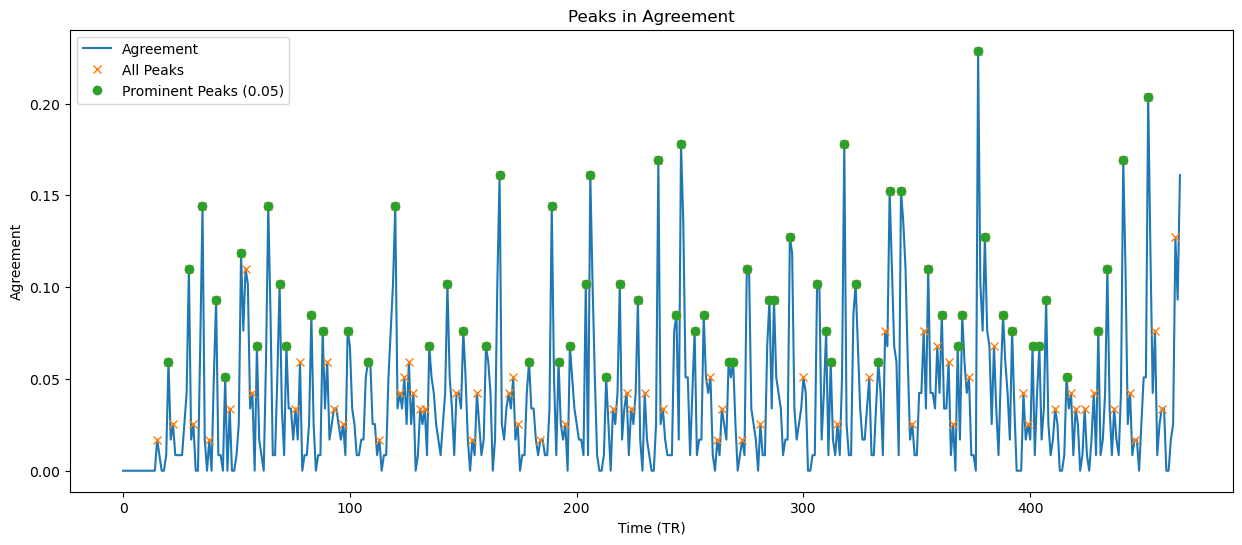

There are 43 prominent (agreement = 0.06) peaks in agreement


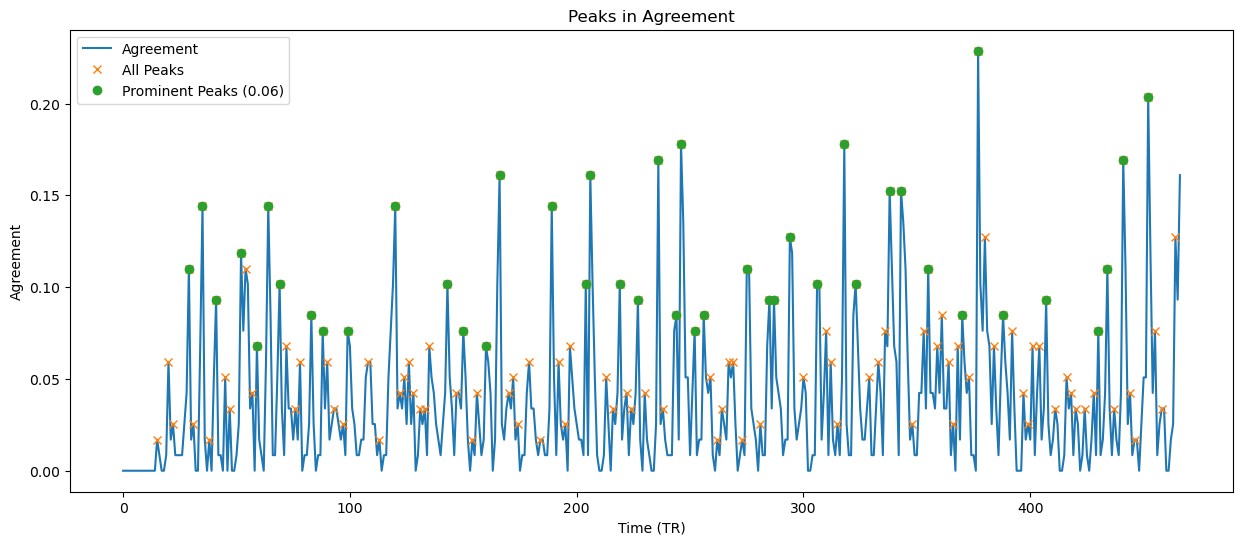

There are 37 prominent (agreement = 0.07) peaks in agreement


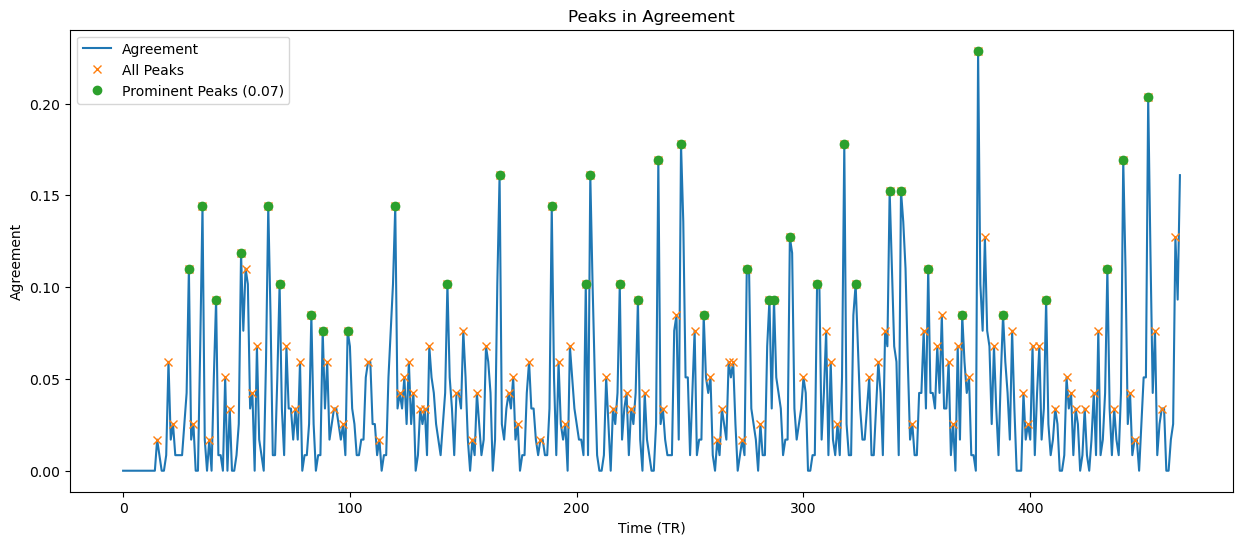

There are 33 prominent (agreement = 0.08) peaks in agreement


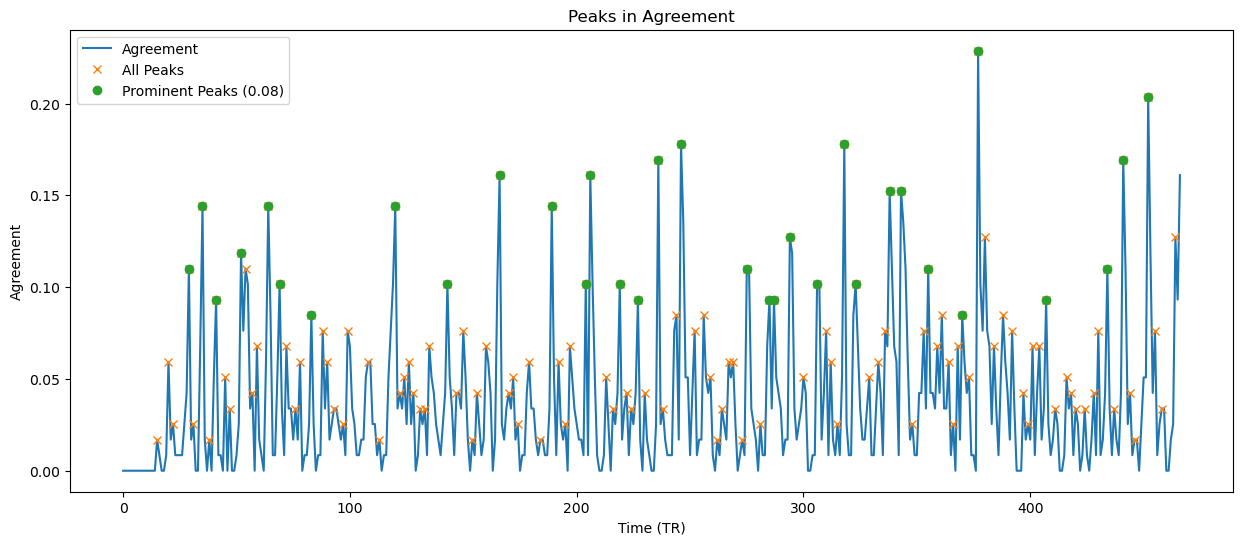

There are 28 prominent (agreement = 0.09) peaks in agreement


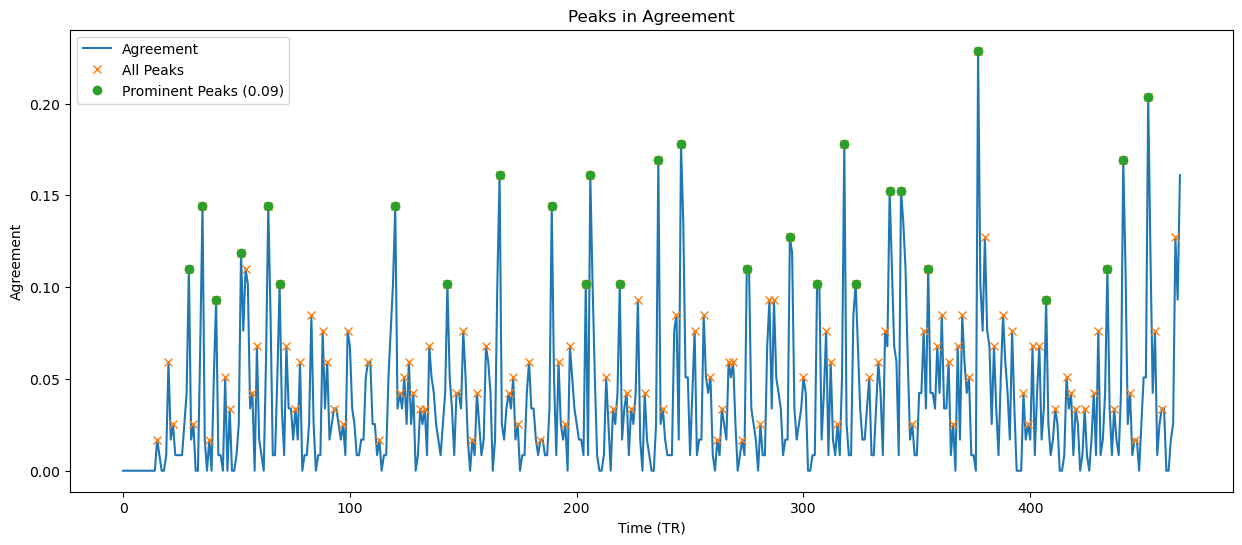

There are 22 prominent (agreement = 0.1) peaks in agreement


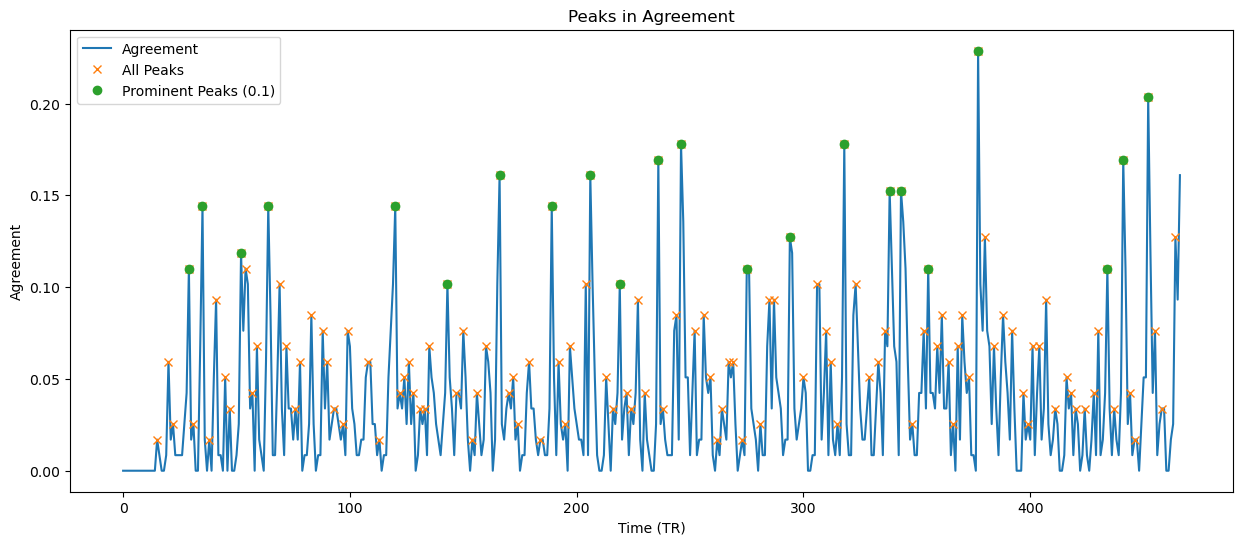

There are 18 prominent (agreement = 0.11) peaks in agreement


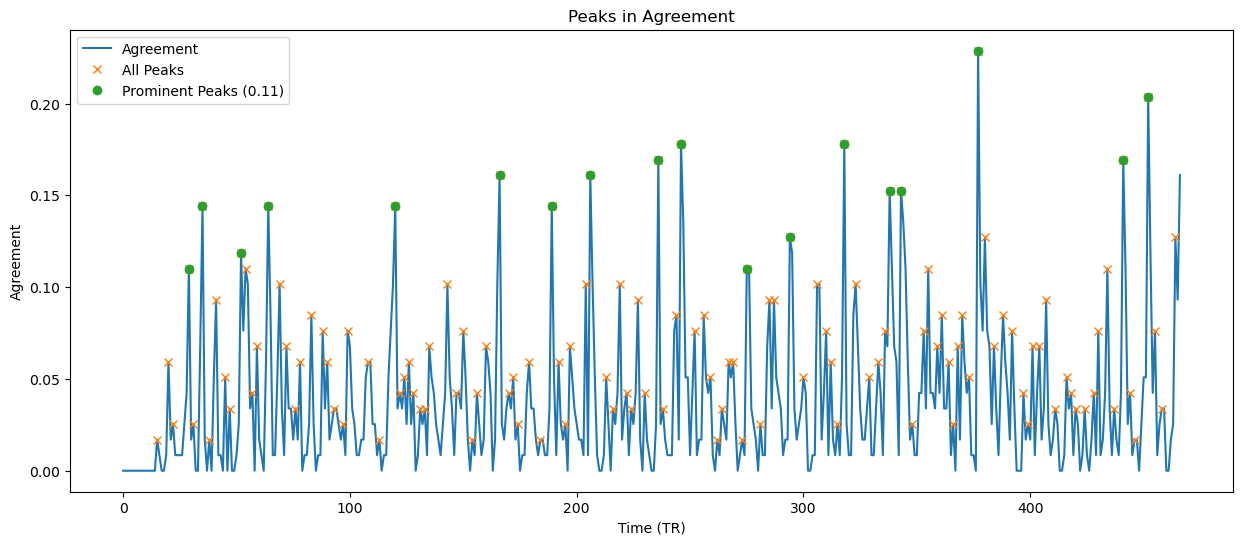

There are 15 prominent (agreement = 0.12) peaks in agreement


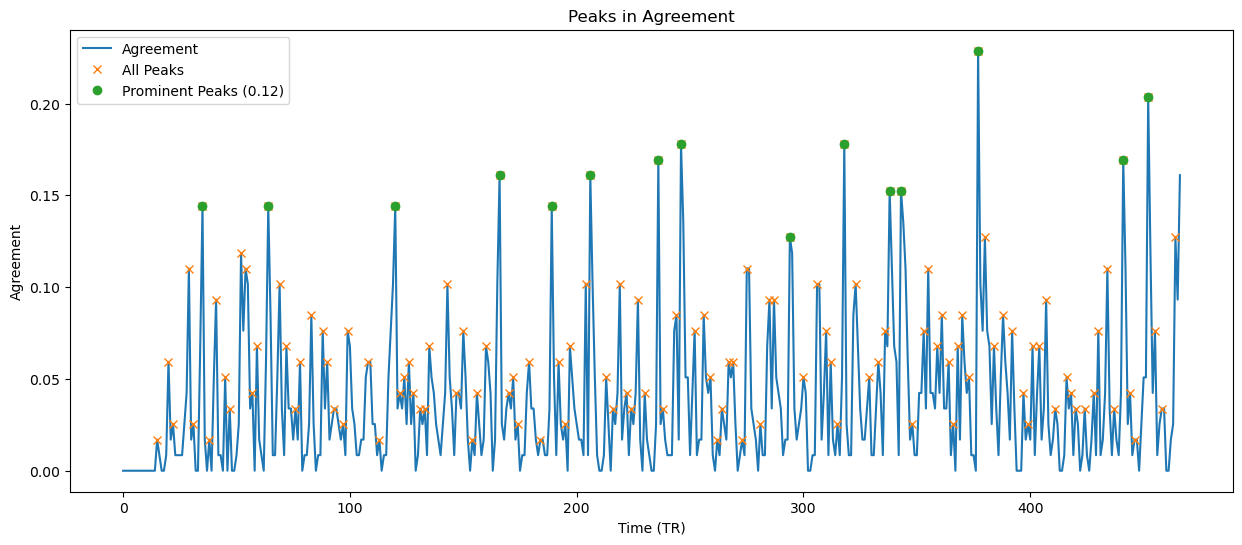

There are 14 prominent (agreement = 0.13) peaks in agreement


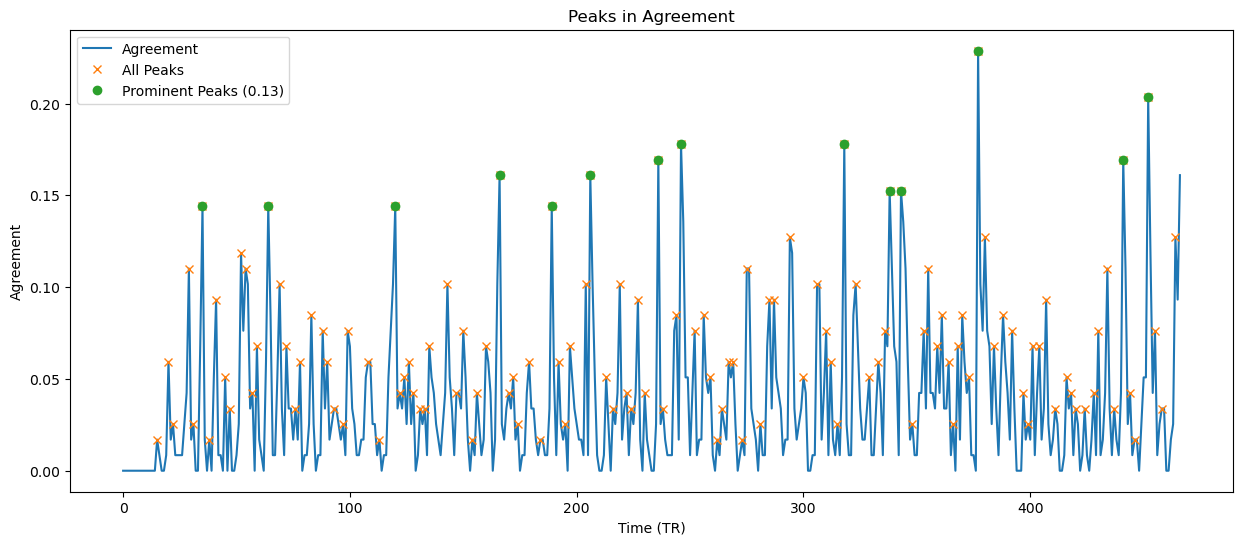

In [30]:
all_peaks, _ = find_peaks(agree_TR_df2['agreement'])
print(f"There are {len(all_peaks)} peaks in agreement")
for prom in [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13]:
    prominent_peaks, _ = find_peaks(agree_TR_df2['agreement'], prominence=prom)
    print(f"There are {len(prominent_peaks)} prominent (agreement = {prom}) peaks in agreement")
    plot_peaks(agree_TR_df2, "TR", all_peaks, prominent_peaks, prom)

There are 124 peaks in agreement
There are 124 (distance = 1) peaks


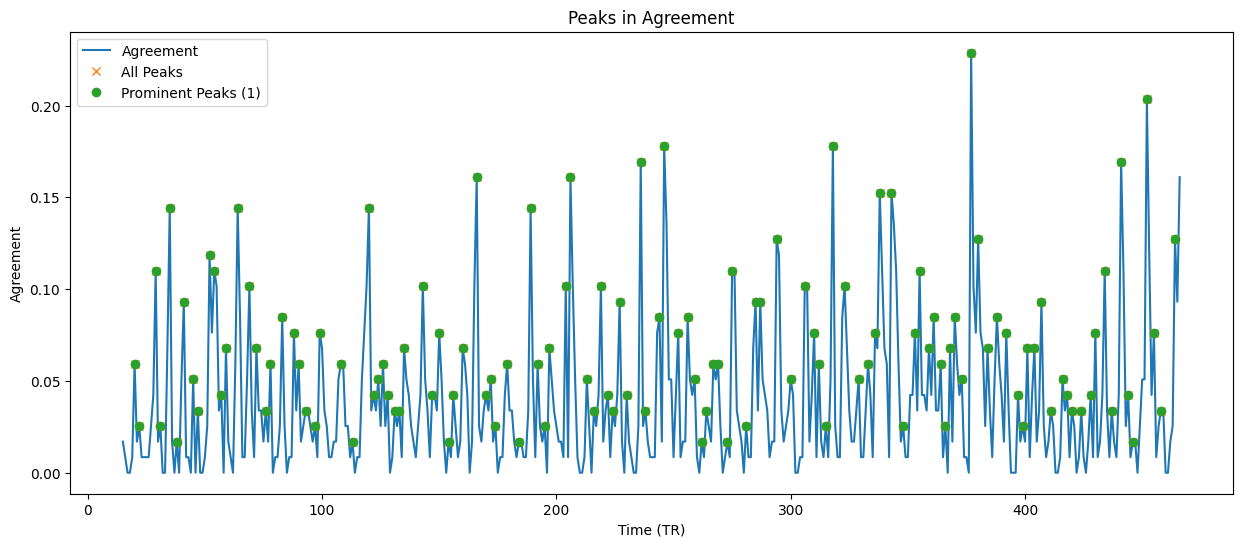

There are 124 (distance = 2) peaks


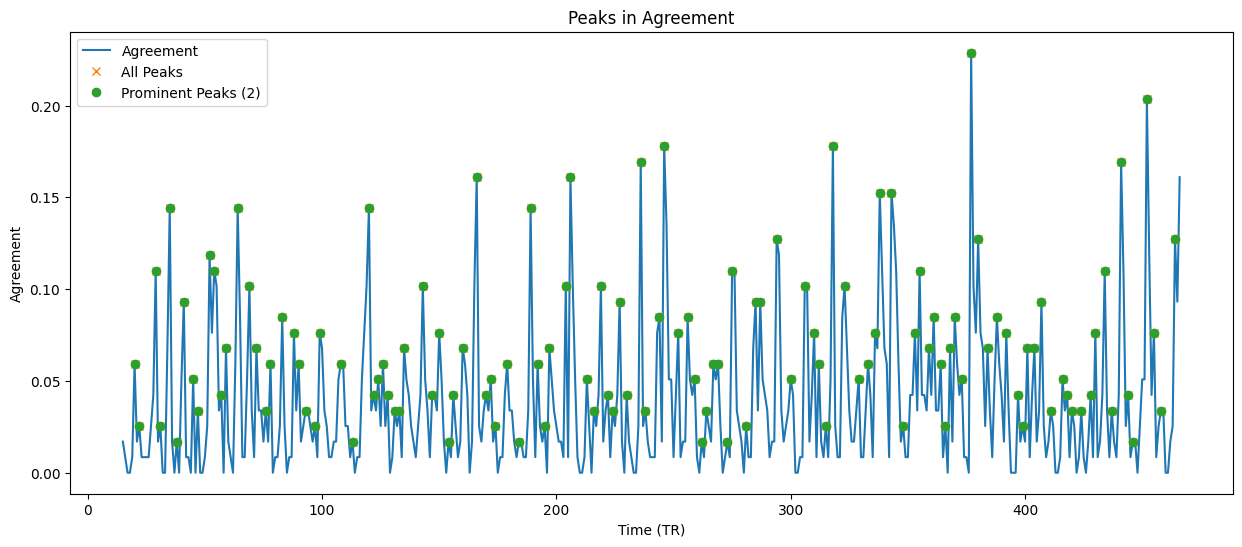

There are 90 (distance = 3) peaks


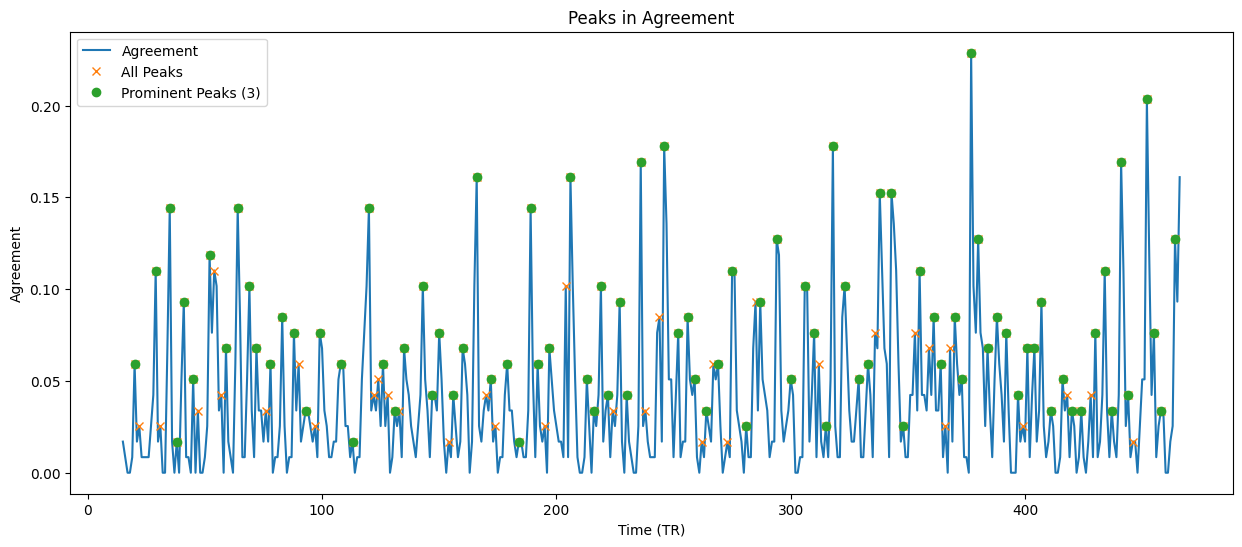

There are 76 (distance = 4) peaks


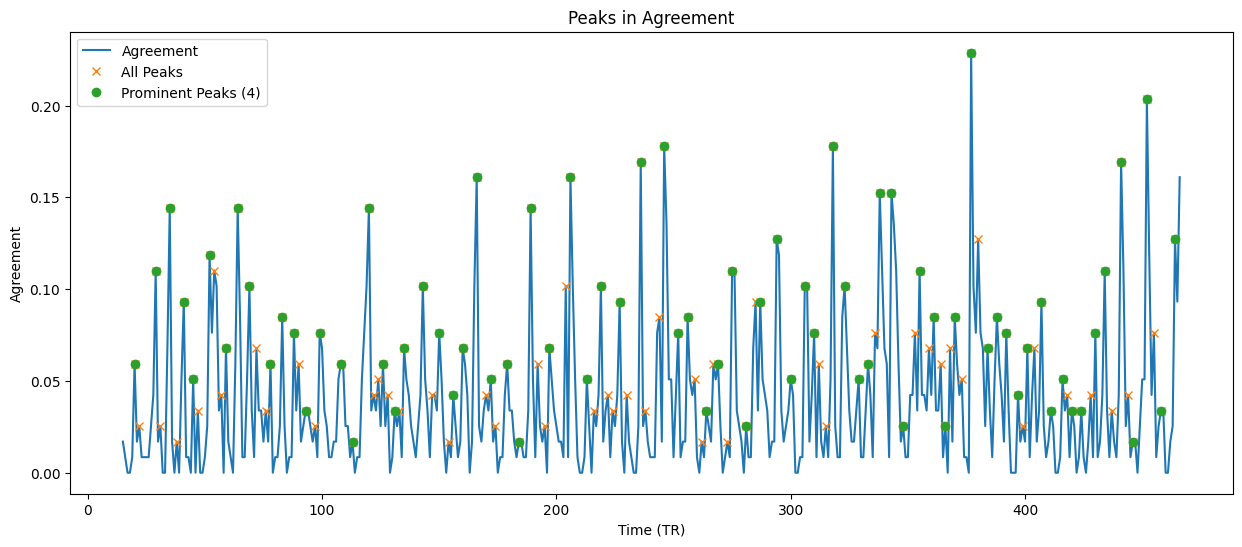

There are 65 (distance = 5) peaks


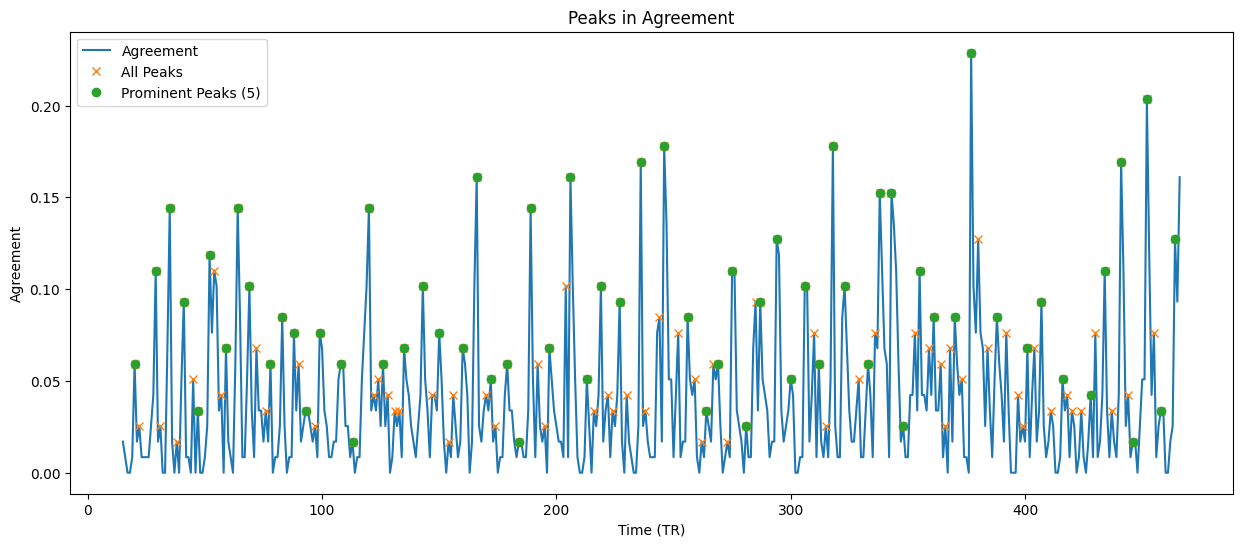

There are 56 (distance = 6) peaks


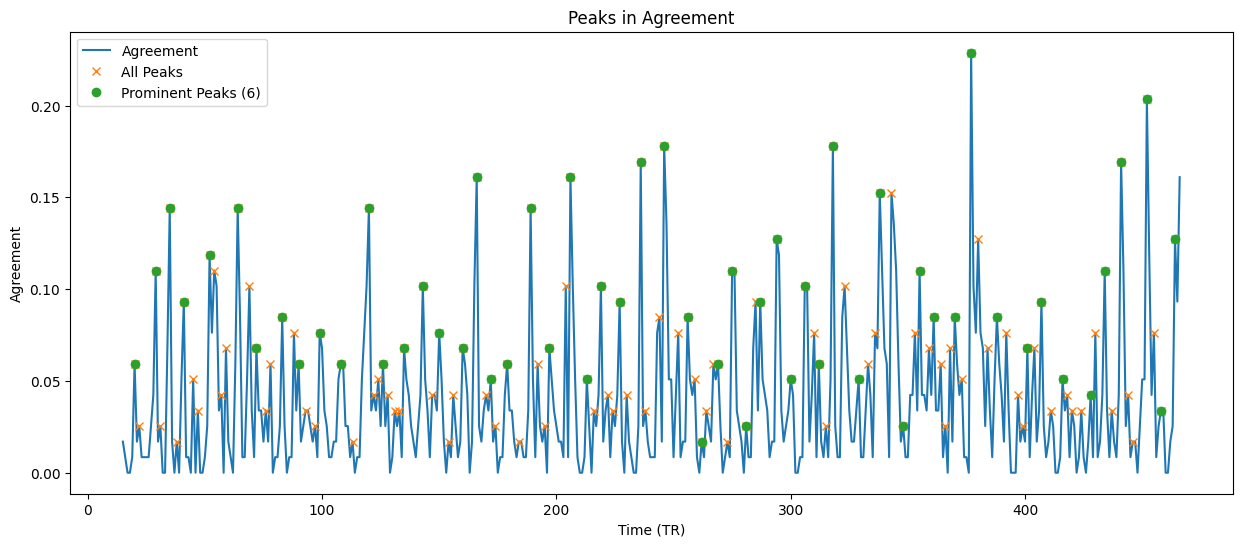

There are 46 (distance = 7) peaks


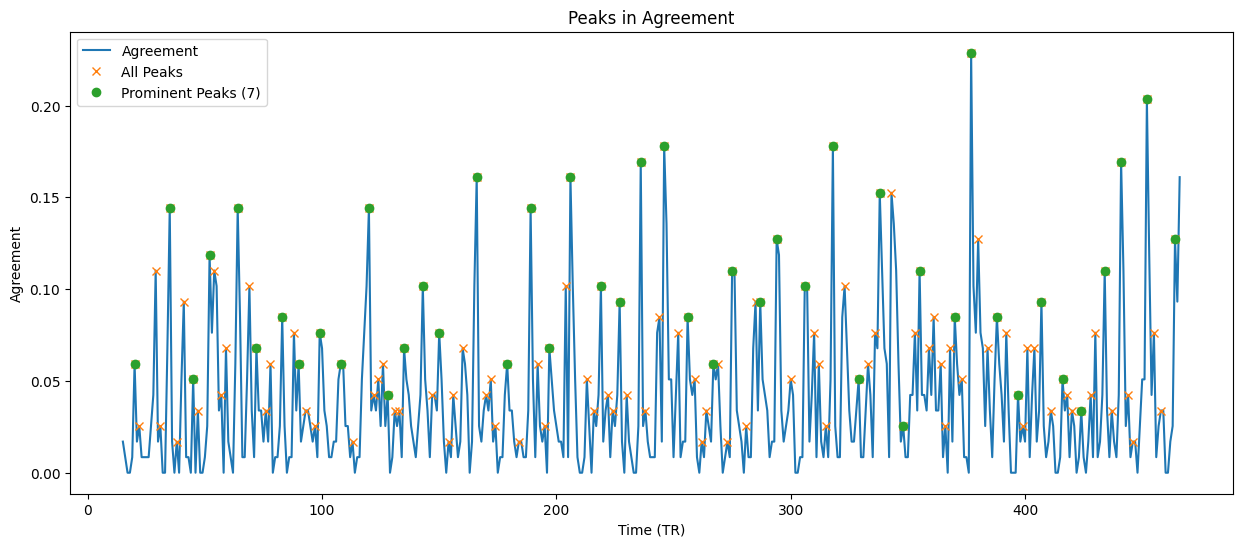

There are 41 (distance = 8) peaks


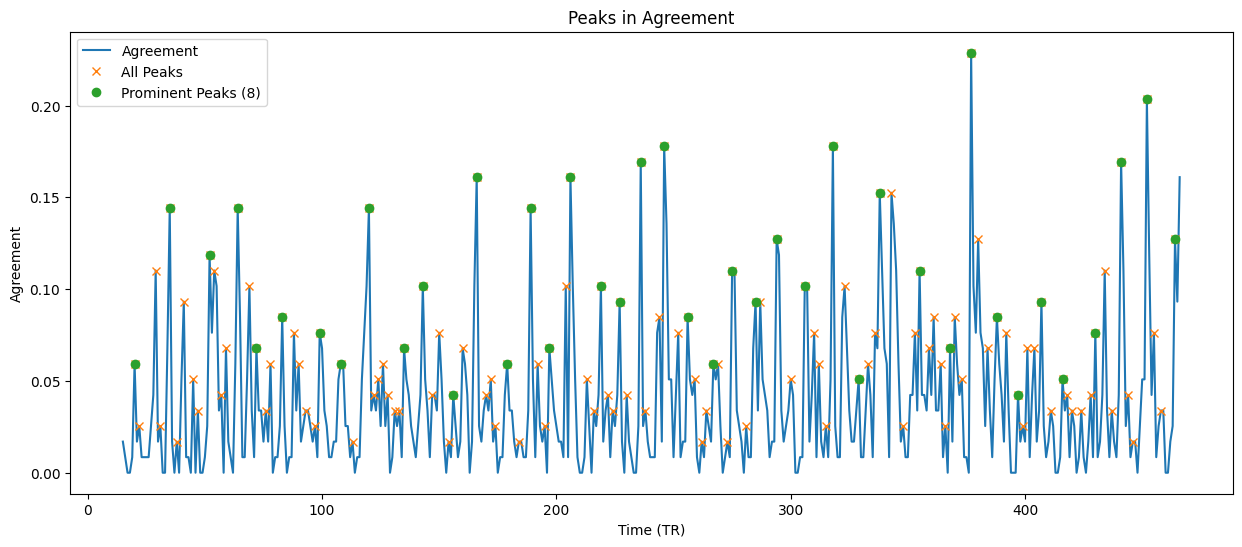

There are 37 (distance = 9) peaks


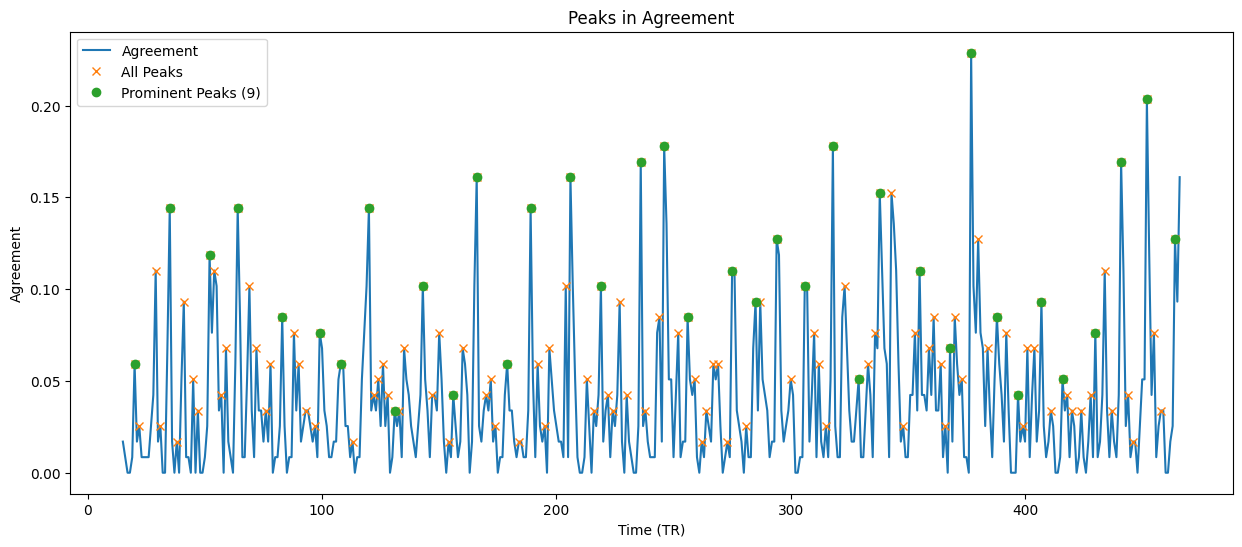

There are 33 (distance = 10) peaks


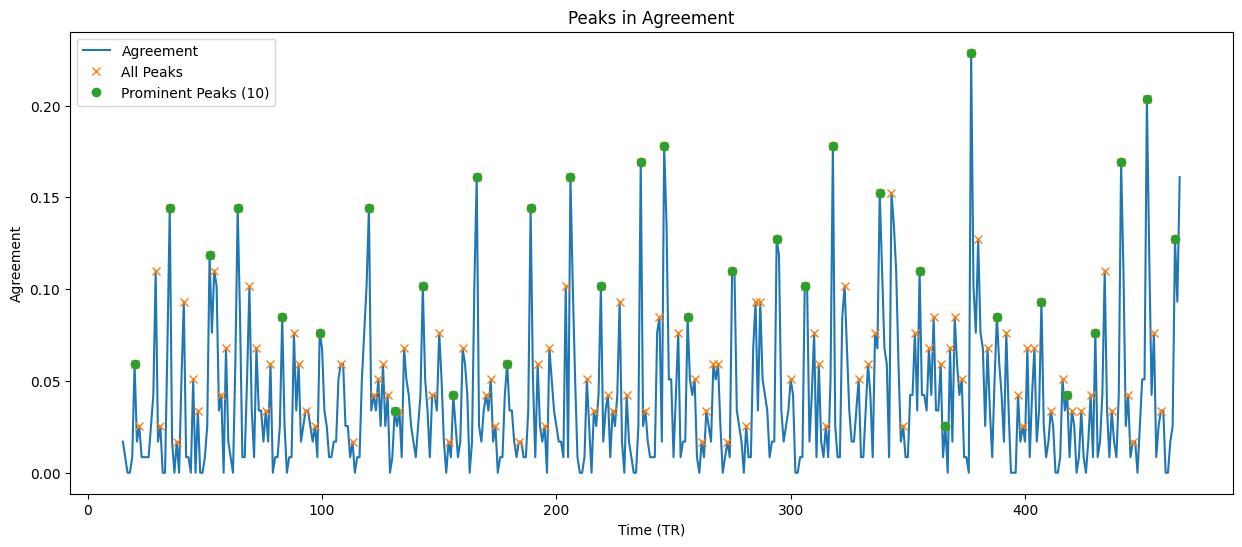

In [18]:
all_peaks, _ = find_peaks(agree_TR_df2['agreement'])
print(f"There are {len(all_peaks)} peaks in agreement")
for dist in [1,2,3,4,5,6,7,8,9,10]:
    dist_peaks, _ = find_peaks(agree_TR_df2['agreement'], distance=dist)
    print(f"There are {len(dist_peaks)} (distance = {dist}) peaks")
    plot_peaks(agree_TR_df2, "TR", all_peaks, dist_peaks, dist)

In [31]:
for prom in [0.08, 0.09, 0.1, 0.11, 0.12]:
    prominent_peaks, _ = find_peaks(agree_TR_df2['agreement'], prominence=prom, distance=5)
    print(f"There are {len(prominent_peaks)} prominent (agreement = {prom}) peaks in agreement")
    print(np.diff(prominent_peaks))
    print(prominent_peaks)


There are 31 prominent (agreement = 0.08) peaks in agreement
[ 6  6 11 12  5 14 37 23 23 23 17 13  8  9 10 29 12  7 12 12  5 15  5 12
 15  7 30 27  7 11]
[ 29  35  41  52  64  69  83 120 143 166 189 206 219 227 236 246 275 287
 294 306 318 323 338 343 355 370 377 407 434 441 452]
There are 27 prominent (agreement = 0.09) peaks in agreement
[ 6  6 11 12  5 51 23 23 23 17 13 17 10 29 19 12 12  5 15  5 12 22 30 27
  7 11]
[ 29  35  41  52  64  69 120 143 166 189 206 219 236 246 275 294 306 318
 323 338 343 355 377 407 434 441 452]
There are 22 prominent (agreement = 0.1) peaks in agreement
[ 6 17 12 56 23 23 23 17 13 17 10 29 19 24 20  5 12 22 57  7 11]
[ 29  35  52  64 120 143 166 189 206 219 236 246 275 294 318 338 343 355
 377 434 441 452]
There are 18 prominent (agreement = 0.11) peaks in agreement
[ 6 17 12 56 46 23 17 30 10 29 19 24 20  5 34 64 11]
[ 29  35  52  64 120 166 189 206 236 246 275 294 318 338 343 377 441 452]
There are 15 prominent (agreement = 0.12) peaks in agreement
[

In [31]:
def seconds2TRs(resp_seconds, TR=1.5):
    resp_seconds = np.array(resp_seconds)
    resp_TRs = np.round(resp_seconds / TR).astype(int)
    resp_TRs = np.unique(resp_TRs)
    return resp_TRs

In [32]:

stimuli_file = os.path.join(stimuli_dir, "segments_speaker.csv")
seg_df = pd.read_csv(stimuli_file, encoding='latin1')
seg_df['onset_TRs'] = seg_df['onset_sec'].apply(lambda x: seconds2TRs(x)[0])
sentence_onset_TRs = np.unique(seg_df['onset_TRs'].tolist())

In [33]:
sentence_onset_TRs

array([  0,   5,  14,  16,  20,  23,  26,  30,  37,  39,  42,  44,  48,
        53,  54,  57,  59,  60,  62,  63,  65,  68,  71,  73,  76,  78,
        79,  80,  82,  85,  87,  88,  91,  92,  94,  96,  97,  98, 100,
       101, 102, 103, 108, 111, 117, 121, 124, 127, 129, 133, 134, 135,
       138, 141, 142, 145, 146, 149, 151, 153, 156, 158, 163, 164, 165,
       166, 167, 170, 174, 175, 178, 183, 184, 189, 191, 198, 201, 203,
       204, 206, 207, 212, 213, 215, 217, 221, 222, 228, 229, 231, 237,
       241, 244, 245, 247, 248, 249, 250, 251, 252, 255, 256, 260, 267,
       269, 272, 274, 277, 279, 284, 285, 287, 288, 291, 292, 297, 299,
       303, 307, 308, 311, 314, 319, 321, 322, 324, 328, 332, 338, 340,
       341, 342, 344, 345, 349, 352, 353, 356, 361, 362, 364, 366, 367,
       368, 369, 372, 374, 377, 380, 383, 384, 386, 389, 391, 392, 401,
       402, 405, 410, 414, 419, 422, 425, 426, 428, 429, 433, 435, 438,
       441, 444, 445, 447, 449])

In [34]:
def filter_elements(A, list_B, delta=3):
    # Find the position where element A would fit in the sorted list
    pos = bisect_left(list_B, A)
    
    # If A is out of bounds of list_B, return None
    if pos == 0 or pos == len(list_B):
        return None
    
    # Identify closest elements to A in list_B
    B = list_B[pos]
    B_prev = list_B[pos - 1]
    
    # Identify next closest elements if they exist
    B_next = list_B[pos + 1] if pos + 1 < len(list_B) else float('inf')
    
    # Filtering conditions
    if A == B:
        return B
    elif B_prev <= A <= min(B_prev + delta, B):
        return B_prev
    elif B <= A <= min(B + delta, B_next):
        return B
    else:
        return None

In [10]:
import pickle

In [95]:
test_dir = "/om2/scratch/tmp/yibei/prettymouth/output/behav_results"
agreement_file1 = os.path.join(test_dir, "agreement_eventseg.pkl")
agreement_file2 = os.path.join(test_dir, "agreement_eventseg_filtered.pkl")

response_file = os.path.join(test_dir, "individual_response_eventseg.pkl")

In [96]:
response_df = pd.read_pickle(agreement_file1)
response_df_filtered = pd.read_pickle(agreement_file2)

In [89]:
response_df

,TR,count,agreement,filtered_TRs
0,14,2,0.017391,14.0
1,16,1,0.008696,16.0
2,19,7,0.060870,16.0
3,20,3,0.026087,20.0
4,21,1,0.008696,20.0
...,...,...,...,...
396,459,2,0.017391,NaN
397,461,2,0.017391,NaN
398,462,2,0.017391,NaN
399,463,8,0.069565,NaN


In [94]:
# Filter out rows where 'filtered_TRs' is NaN before concatenation
all_filtered_TRs = np.concatenate(
    [np.repeat(row['filtered_TRs'], int(row['count'])) 
     for _, row in response_df.iterrows() 
     if not np.isnan(row['filtered_TRs'])]
)

print(all_filtered_TRs)

[ 14.  14.  16. ... 449. 449. 449.]


In [93]:
all_filtered_TRs

array([14., 14., 16., ..., nan, nan, nan])

In [97]:
response_df_filtered

,TR,count,agreement
0,14.0,2,0.017391
1,16.0,8,0.069565
2,20.0,8,0.069565
3,23.0,2,0.017391
4,26.0,26,0.226087
...,...,...,...
161,441.0,29,0.252174
162,444.0,4,0.034783
163,445.0,3,0.026087
164,447.0,1,0.008696


In [67]:
with open(response_file, 'rb') as f:
    response = pickle.load(f)

In [68]:
response

,key_resp_2.TR,binary_response,participant
2,"[28, 37, 56, 96, 132, 196, 218, 355]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",64c272ab2d76c8ae50811355
8,"[35, 63, 119, 135, 161, 189, 203, 222, 236, 24...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6070b8550e199cd6db5e4a79
12,"[55, 79, 88, 126, 162, 169, 184, 198, 230, 249...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",60baaa995c09d3162511871d
16,"[19, 22, 24, 28, 34, 40, 44, 46, 51, 53, 56, 6...","[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, ...",6100943a3afefd2133a6f0f7
26,"[35, 54, 65, 148, 155, 200, 250, 275, 306, 317...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5cead89f7832f40018ca2245
...,...,...,...
536,"[11, 53, 89, 109, 124, 136, 166, 192, 238, 247...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",633f4f203450d46b01e3d16b
540,"[65, 203, 226, 246, 284, 318, 340, 388, 439, 465]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5c4b376788975200015652d4
544,[13],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",63d13b764f00a53476867c25
548,"[54, 68, 344, 377, 386, 452]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",57dd186e6598aa0001992616


In [42]:
response_df

,TR,count,agreement
0,14,2,0.017391
1,16,1,0.008696
2,19,7,0.060870
3,20,3,0.026087
4,21,1,0.008696
...,...,...,...
396,459,2,0.017391
397,461,2,0.017391
398,462,2,0.017391
399,463,8,0.069565


In [86]:
response_df_filtered

,TR,count,agreement
0,14.0,2,0.004988
1,16.0,8,0.019950
2,20.0,8,0.019950
3,23.0,2,0.004988
4,26.0,26,0.064838
...,...,...,...
473,NaN,1,0.002494
474,NaN,1,0.002494
475,NaN,1,0.002494
476,NaN,1,0.002494


In [38]:
agreement_df

,TR,count,agreement,filtered_TRs
0,14,2,0.017391,14.0
1,16,1,0.008696,16.0
2,19,7,0.060870,16.0
3,20,3,0.026087,20.0
4,21,1,0.008696,20.0
...,...,...,...,...
396,459,2,0.017391,NaN
397,461,2,0.017391,NaN
398,462,2,0.017391,NaN
399,463,8,0.069565,NaN


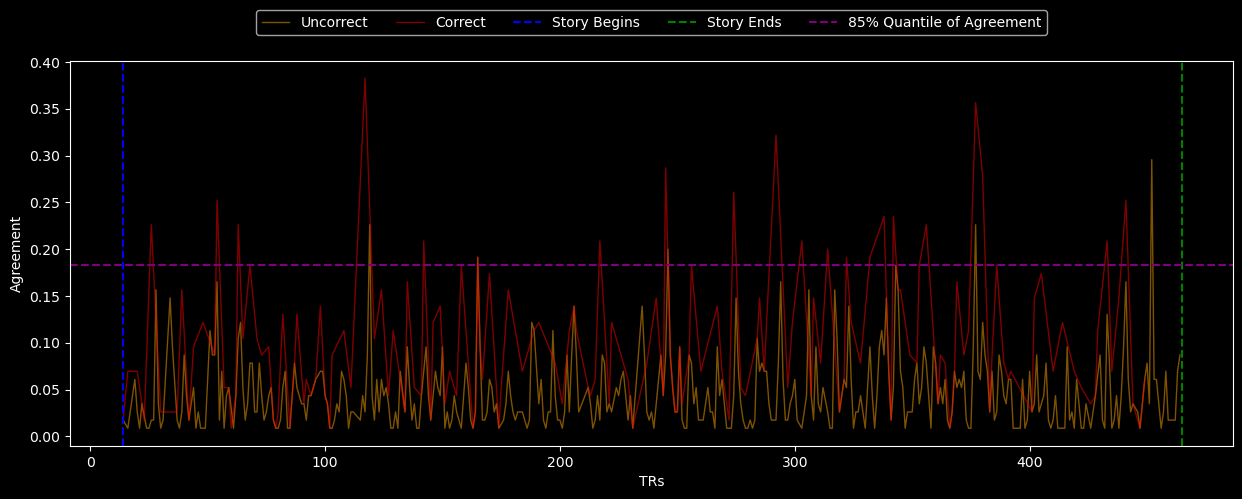

In [45]:
# make a scatter plot with line
# agreement is the y axis
# TR is the x axis
fig, ax1 = plt.subplots(figsize=(15, 5))
# ax1.scatter(response_df['TR'], response_df['agreement'], color='r', s=1, alpha=0.5)
ax1.plot(response_df['TR'], response_df['agreement'], color='orange', linewidth=1, alpha=0.5, label="Uncorrect")
ax1.plot(response_df_filtered['TR'], response_df_filtered['agreement'], color='r', linewidth=1, alpha=0.5, label="Correct")
ax1.set_xlabel("TRs")
ax1.set_ylabel("Agreement")
ax1.axvline(x=14, color='b', linestyle='--', label="Story Begins")
ax1.axvline(x=465, color='g', linestyle='--', label="Story Ends")
th = response_df_filtered['agreement'].quantile(0.85)
ax1.axhline(y=th, color='purple', linestyle='--', label="85% Quantile of Agreement")
# add label to the legend and put the legend to the center
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=5)
plt.show()

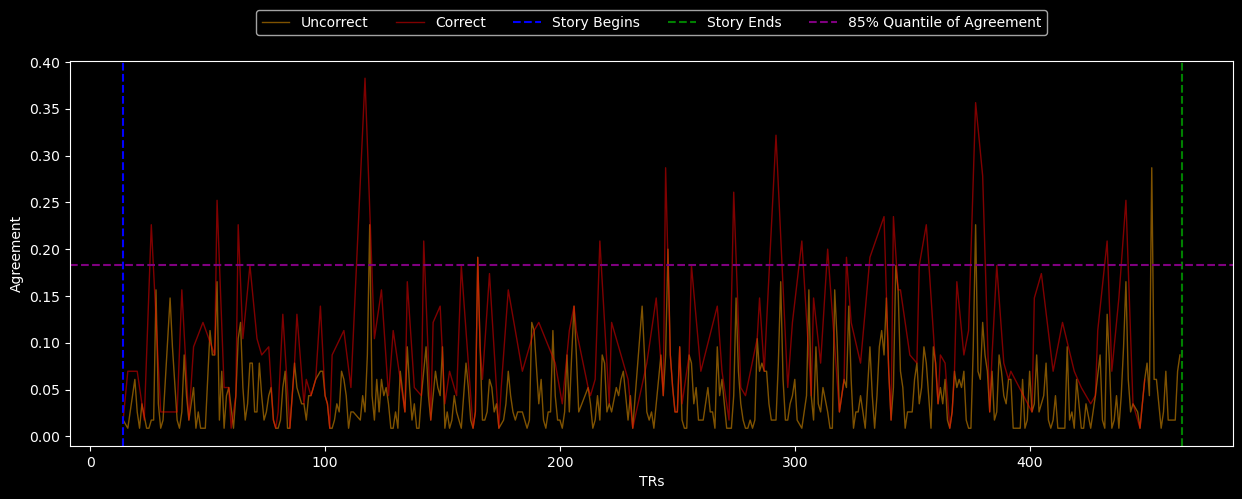

In [98]:
# make a scatter plot with line
# agreement is the y axis
# TR is the x axis
fig, ax1 = plt.subplots(figsize=(15, 5))
# ax1.scatter(response_df['TR'], response_df['agreement'], color='r', s=1, alpha=0.5)
ax1.plot(response_df['TR'], response_df['agreement'], color='orange', linewidth=1, alpha=0.5, label="Uncorrect")
ax1.plot(response_df_filtered['TR'], response_df_filtered['agreement'], color='r', linewidth=1, alpha=0.5, label="Correct")
ax1.set_xlabel("TRs")
ax1.set_ylabel("Agreement")
ax1.axvline(x=14, color='b', linestyle='--', label="Story Begins")
ax1.axvline(x=465, color='g', linestyle='--', label="Story Ends")
th = response_df_filtered['agreement'].quantile(0.85)
ax1.axhline(y=th, color='purple', linestyle='--', label="85% Quantile of Agreement")
# add label to the legend and put the legend to the center
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=5)
plt.show()

In [54]:
import pandas as pd
import numpy as np

# Sample input data
data = {
    'TR': [14, 16, 19, 20, 21, 459, 461, 462, 463, 464],
    'count': [2, 1, 7, 3, 1, 2, 2, 2, 8, 10],
    'agreement': [0.017391, 0.008696, 0.060870, 0.026087, 0.008696, 0.017391, 0.017391, 0.017391, 0.069565, 0.086957],
    'filtered_TRs': [14.0, 16.0, 16.0, 20.0, 20.0, np.nan, np.nan, np.nan, np.nan, np.nan]
}
df = pd.DataFrame(data)

# Function to generate time series DataFrame
def get_tsdf(df, n_TR=451):
    unit = 'TR'
    ts_df = pd.DataFrame({unit: np.arange(n_TR)})
    
    # Merge the input DataFrame with the ts_df on the 'TR' column
    ts_df = ts_df.merge(df[[unit, "agreement"]], on=unit, how='left').fillna(0)
    
    return ts_df

# Generate time series DataFrame
ts_df = get_tsdf(df)
print(ts_df)

      TR  agreement
0      0        0.0
1      1        0.0
2      2        0.0
3      3        0.0
4      4        0.0
..   ...        ...
446  446        0.0
447  447        0.0
448  448        0.0
449  449        0.0
450  450        0.0

[451 rows x 2 columns]


In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import logging
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import ast
from bisect import bisect_left
from collections import Counter
from scipy.signal import find_peaks

In [2]:
load_dotenv()
base_dir = os.getenv("SCRATCH_DIR")

if not base_dir:
    logging.error("BASE_DIR environment variable not set")
    raise EnvironmentError("BASE_DIR environment variable not set")

data_dir = os.path.join(base_dir, "data")
behav_dir = os.path.join(data_dir, "behav")
stimuli_dir = os.path.join(data_dir, "stimuli")
output_dir = os.path.join(base_dir, "output", "behav_results")
os.makedirs(output_dir, exist_ok=True)

stimuli_file1 = os.path.join(stimuli_dir, "word_by_onset.csv")
word_df = pd.read_csv(stimuli_file1, encoding='latin1')
stimuli_file2 = os.path.join(stimuli_dir, "segments_speaker.csv")
seg_df = pd.read_csv(stimuli_file2, encoding='latin1')

df_1 = pd.read_csv(os.path.join(behav_dir, "prettymouth1.csv"))
df_2a = pd.read_csv(os.path.join(behav_dir, "prettymouth2a.csv"))
df_2b = pd.read_csv(os.path.join(behav_dir, "prettymouth2b.csv"))
df_1_postsurvey = pd.read_csv(os.path.join(behav_dir, "prettymouth1_postsurvey.csv")).iloc[2:]
df_2_postsurvey = pd.read_csv(os.path.join(behav_dir, "prettymouth2_postsurvey.csv")).iloc[2:]

df_1_response = df_1.dropna(subset=["key_resp_2.rt"])
df_2a_response = df_2a.dropna(subset=["key_resp_2.rt"])
df_2b_response = df_2b.dropna(subset=["key_resp_2.rt"])

common_participants_1 = set(df_1_response["participant"]).intersection(df_1_postsurvey["participant"])
common_participants_2a = set(df_2a_response["participant"]).intersection(df_2_postsurvey["participant"])
common_participants_2b = set(df_2b_response["participant"]).intersection(df_2_postsurvey["participant"])

df1 = df_1_response[df_1_response["participant"].isin(common_participants_1)]
df2a = df_2a_response[df_2a_response["participant"].isin(common_participants_2a)]
df2b = df_2b_response[df_2b_response["participant"].isin(common_participants_2b)]

In [3]:
def seconds2TRs(resp_seconds, TR=1.5):
    logging.info("Converting seconds to TRs")
    resp_seconds = np.array(resp_seconds)
    resp_TRs = np.unique(np.round(resp_seconds / TR).astype(int))
    return resp_TRs

def convert2binary(lst, size):
    logging.info("Converting list to binary array")
    binary_array = np.zeros(size, dtype=int)
    valid_indices = np.array(lst)
    valid_indices = valid_indices[valid_indices < size]
    binary_array[valid_indices] = 1
    return binary_array

def convert_to_TRs(df, TR, n_TR=465):
    logging.info("Converting response times to TRs")
    df['key_resp_2.rt'] = df['key_resp_2.rt'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['key_resp_2.TR'] = df['key_resp_2.rt'].apply(lambda x: seconds2TRs(x, TR))
    df['binary_response'] = df['key_resp_2.TR'].apply(lambda x: convert2binary(x, n_TR))
    return df[['key_resp_2.TR', 'binary_response', 'participant']].copy()

def get_agreement(df, unit='TR'):
    logging.info("Calculating agreement")
    response_col = 'key_resp_2.TR'
    
    all_responses = np.concatenate(df[response_col].dropna().values)
    
    response_counts = Counter(all_responses)
    agreement_df = pd.DataFrame(list(response_counts.items()), columns=[unit, 'count'])
    agreement_df = agreement_df.sort_values(by=unit).reset_index(drop=True)
    agreement_df['agreement'] = agreement_df['count'] / df.shape[0]
    
    if unit == 'TR':
        agreement_df = agreement_df[(agreement_df[unit] >= 14) & (agreement_df[unit] < 465)]
        # agreement_df[unit] = agreement_df[unit] - 14
    elif unit == 'second':
        agreement_df = agreement_df[(agreement_df[unit] >= 21) & (agreement_df[unit] < 697)]
        # agreement_df[unit] = agreement_df[unit] - 21
    else:
        logging.error("Invalid unit provided")
        raise ValueError("Please enter a valid unit: TR or second")
    
    agreement_df = agreement_df.reset_index(drop=True)
    return agreement_df

def get_tsdf(df, n_TR=465):
    logging.info("Generating time series DataFrame")
    unit = 'TR'
    ts_df = pd.DataFrame({unit: np.arange(n_TR)})
    
    ts_df = ts_df.merge(df[[unit, "agreement"]], on=unit, how='left').fillna(0)
    return ts_df

def filter_elements(A, list_B, delta=3):
    """
    Filters a given element A based on its proximity to elements in a sorted list B.

    This function determines whether a given key response timepoint (A) is close to 
    a boundary (e.g., beginning or end of a sentence, or a pause in the speech) 
    in a sorted list of boundary timepoints (list_B). If A is within a threshold 
    delta of a boundary, the closest boundary timepoint is returned; otherwise, None is returned.

    Args:
        A (float or int): The key response timepoint to be evaluated.
        list_B (list of float or int): A sorted list of boundary timepoints.
        delta (float or int, optional): The maximum allowable distance for A to be considered close to a boundary. Default is 3.

    Returns:
        float or None: The closest boundary timepoint if A is within delta of a boundary, otherwise None.
    
    Methodology:
        - Behavioral data (key response) can be delayed even if our brain realizes there is a boundary.
        - The function examines each key response timepoint (A) and checks whether it is close to a boundary
          in list_B within the given threshold delta.
        - If A is close to a boundary (within delta), the closest boundary timepoint is returned.
        - If no close boundary is found, the function returns None.
    
    Examples:
        >>> filter_elements(10, [7, 11, 15], delta=3)
        11
        >>> filter_elements(5, [7, 11, 15], delta=3)
        None
    """
    pos = bisect_left(list_B, A)
    if pos == 0 or pos == len(list_B):
        return None

    B = list_B[pos]
    B_prev = list_B[pos - 1]

    B_next = list_B[pos + 1] if pos + 1 < len(list_B) else float('inf')

    if A == B:
        return B
    elif B_prev <= A <= min(B_prev + delta, B):
        return B_prev
    elif B <= A <= min(B + delta, B_next):
        return B
    return None

def create_event_df(prom, prominent_peaks, word_df, filepath):
    logging.info(f"Creating event DataFrame for prominence {prom}")
    events = []
    for i, n in enumerate(prominent_peaks):
        start = 14 if i == 0 else prominent_peaks[i-1]
        end = word_df["TR"].max() if i == len(prominent_peaks)-1 else n
        text = " ".join(word_df.loc[(word_df["TR"] >= start) & (word_df["TR"] <= end), "text"].values)
        events.append({"start_TR": start, "end_TR": end, "text": text})
    event_df = pd.DataFrame(events)
    event_df.to_csv(filepath, index=False)

In [4]:
response_df1 = convert_to_TRs(df1, 1.5)
response_df2a = convert_to_TRs(df2a, 1.5)
response_df2b = convert_to_TRs(df2b, 1.5)

In [6]:
agree_TR_df1 = get_agreement(response_df1)
agree_TR_df2a = get_agreement(response_df2a)
agree_TR_df2b = get_agreement(response_df2b)

In [7]:
agree_TR_df1

,TR,count,agreement
0,14,2,0.017391
1,16,1,0.008696
2,19,7,0.060870
3,20,3,0.026087
4,21,1,0.008696
...,...,...,...
396,459,2,0.017391
397,461,2,0.017391
398,462,2,0.017391
399,463,8,0.069565


In [23]:
mean_response = np.vstack(response_df1["binary_response"].values).mean(axis=0)
count_response = np.vstack(response_df1["binary_response"].values).sum(axis=0)
agreement_df = pd.DataFrame({'TR': np.arange(len(mean_response)), 'agreement': mean_response, 'count': count_response})

In [17]:
agreement_df

,TR,mean_response,count_response
0,0,0.000000,0
1,1,0.008696,1
2,2,0.008696,1
3,3,0.000000,0
4,4,0.008696,1
...,...,...,...
460,460,0.000000,0
461,461,0.017391,2
462,462,0.017391,2
463,463,0.069565,8


In [18]:
seg_df['onset_TRs'] = seg_df['onset_sec'].apply(lambda x: seconds2TRs(x)[0])
sentence_onset_TRs = np.unique(seg_df['onset_TRs'])

In [22]:
agreement_df['filtered_TRs'] = agreement_df['TR'].apply(lambda x: filter_elements(x, sentence_onset_TRs))

# Filter out rows where 'filtered_TRs' is NaN before concatenation
all_filtered_TRs = np.concatenate(
    [np.repeat(row['filtered_TRs'], int(row['count'])) 
    for _, row in agreement_df.iterrows() 
    if not np.isnan(row['filtered_TRs'])]
)

KeyError: 'count'

In [19]:
individual_res = np.vstack(response_df1["binary_response"].values)

In [20]:
individual_res

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [21]:
response_df1

,key_resp_2.TR,binary_response,participant
2,"[28, 37, 56, 96, 132, 196, 218, 355]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",64c272ab2d76c8ae50811355
8,"[35, 63, 119, 135, 161, 189, 203, 222, 236, 24...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6070b8550e199cd6db5e4a79
12,"[55, 79, 88, 126, 162, 169, 184, 198, 230, 249...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",60baaa995c09d3162511871d
16,"[19, 22, 24, 28, 34, 40, 44, 46, 51, 53, 56, 6...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6100943a3afefd2133a6f0f7
26,"[35, 54, 65, 148, 155, 200, 250, 275, 306, 317...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5cead89f7832f40018ca2245
...,...,...,...
536,"[11, 53, 89, 109, 124, 136, 166, 192, 238, 247...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",633f4f203450d46b01e3d16b
540,"[65, 203, 226, 246, 284, 318, 340, 388, 439, 465]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5c4b376788975200015652d4
544,[13],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",63d13b764f00a53476867c25
548,"[54, 68, 344, 377, 386, 452]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",57dd186e6598aa0001992616
